# K-means from scratch

$$\newcommand{\vec}{\mathbf}\newcommand{\mat}{\mathbf}$$
* Cluster unlabeled data


In [65]:
using PyPlot

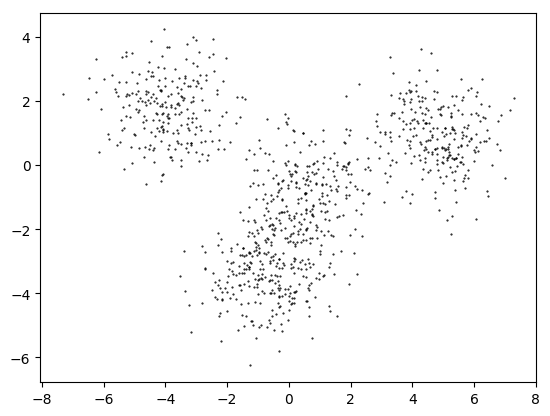

2×1000 Array{Float64,2}:
 -0.238954  -2.81391  5.79397   0.200144  …  0.143204  5.91416  5.53676 
 -4.96322    2.02804  1.2531   -2.92428      1.0862    1.59531  0.095083

In [66]:
# number of data points
N = 1000
# number of dimensins
n = 2
# generate random data
srand(1234)
x = randn(n,N)
nc = 4
xc_true = 3 * randn(n,nc)

for i = 1:N
    ic = rand(1:nc)
    x[:,i] = xc_true[:,ic] + randn(2)
end

plot(x[1,:],x[2,:],"k.",markersize = 1);
x

Let's try to find the centroid of the k clusters. Here k is 4 

In [67]:
k = 4

4

 Pick $k$ random elements of $x$ as initial centroids. This is the Forgy method for initialization.

In [68]:
xc = x[:,rand(1:N,k)]

2×4 Array{Float64,2}:
 1.55109   -1.45972   0.626195  -1.15342 
 0.107881  -3.70148  -3.82496   -0.554834

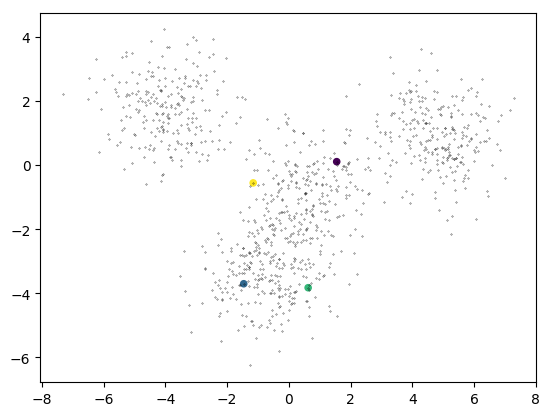

In [69]:
plot(x[1,:],x[2,:],"k.",markersize=0.5)
scatter(xc[1,:],xc[2,:],20,1:k);

We are just using the Euclidian distance here

In [70]:
distance(x,y) = sum((x-y).^2)

distance (generic function with 1 method)

To each data point $x_i$ (`x[:,i]`) assign the label correspond to the closest centroid.

In [71]:
label = zeros(Int,N)

function assignlabel!(x,xc,distance,label)
    N = size(x,2)
    k = size(xc,2)
    for i = 1:N
      mindist = 1e10
      for j = 1:k
        dist = distance(x[:,i],xc[:,j])
        if dist < mindist
           label[i] = j
           mindist = dist
        end
      end
    end
end
assignlabel!(x,xc,distance,label)

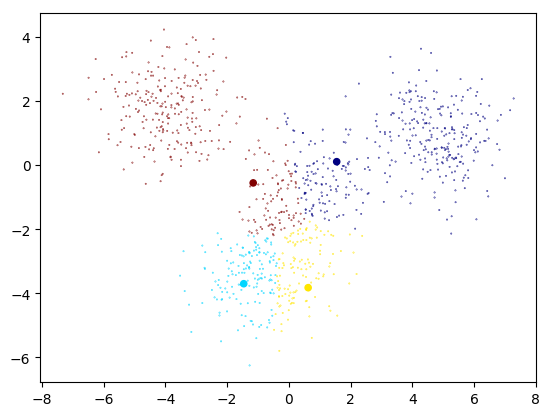

In [72]:
function plotcluster(x,label,xc)
    k = size(xc,2)
    scatter(xc[1,:],xc[2,:],20,1:k; cmap = "jet")
    scatter(x[1,:],x[2,:],0.1,label; cmap = "jet")
end
plotcluster(x,label,xc);

Update the centroids `xcnew` based on the labels

In [73]:
function updatemeans!(x,label,xcnew)
  k = size(xcnew,2)

  for j = 1:k;
    xcnew[:,j] = mean(x[:,label .== j],2)
  end
end

xcnew = similar(xc)
updatemeans!(x,label,xcnew)
xcnew

2×4 Array{Float64,2}:
 3.58948   -1.40562   0.438302  -2.90465
 0.476353  -3.49479  -3.29097    0.93377

Old and new centroids (light and draker color)

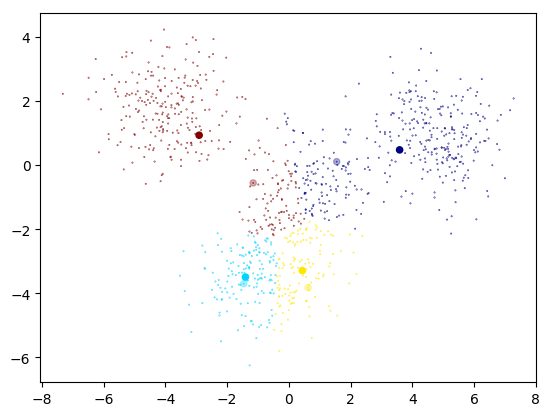

In [74]:
plotcluster(x,label,xcnew)
scatter(xc[1,:],xc[2,:],20,1:k; cmap = "jet", alpha = 0.3);

Iterate over label assignmement and updating the centroids

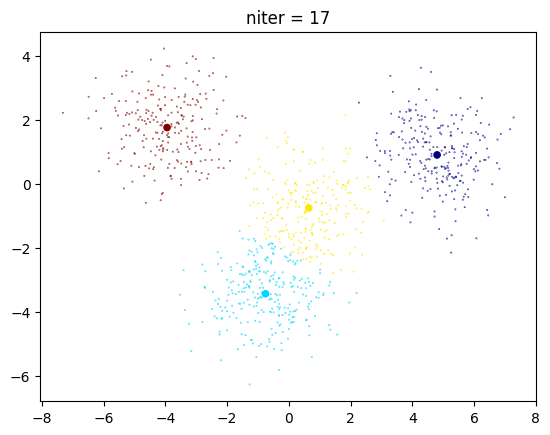

INFO: Converged


In [75]:
xc = x[:,rand(1:N,k)]
nmaxiter = 100
newlabel = zeros(Int,N)
fig = figure()
for niter = 1:nmaxiter
    assignlabel!(x,xc,distance,newlabel)
    updatemeans!(x,newlabel,xcnew)
 
    xc .= xcnew
    plotcluster(x,newlabel,xcnew)
    title("niter = $(niter)")
    sleep(1)
    IJulia.clear_output(true)
    display(fig)
    clf()
    
    if label == newlabel
        info("Converged")
        break
    end
    label .= newlabel     
end



Note how sometimes the algorithm does not converge

In [76]:
xc

2×4 Array{Float64,2}:
 4.80477   -0.754602   0.646769  -3.94462
 0.912755  -3.42157   -0.744018   1.76655

In [77]:
xc_true

2×4 Array{Float64,2}:
 -3.91166   0.526458  -0.789345  4.7484  
  1.76087  -0.828008  -3.40463   0.877456

Note the connection to the [Voroni diagram](https://en.wikipedia.org/wiki/Voronoi_diagram)


# Gaussian mixture

In [78]:
n

2

A Gaussian pdf is given by its mean $\vec \mu$ and its covariance matrix $\mat \Sigma$

$$
p(\vec x) = \frac{1}{\sqrt{2\pi \det(\mat \Sigma)}} \exp\left(-\frac{1}{2} (\vec x - \vec μ)^T  \mat Σ^{-1} (\vec x - \vec μ) \right)
$$

In [79]:
Gaussian(x,μ,Σ) =  1/(sqrt(2π * det(Σ))) * exp(- (x - μ)' * (Σ \ (x - μ) )/2 )

Gaussian (generic function with 1 method)

A gaussian mixture model is a linear combination of Gaussians

$$
p'(\vec x) = \sum_{l=1}^k \frac{\phi_l}{\sqrt{2\pi \det(\mat \Sigma_l)}} \exp\left(-\frac{1}{2} (\vec x - \vec μ_l)^T  \mat Σ_l^{-1} (\vec x - \vec μ_l) \right)
$$

where all coefficients $\phi_l$ are positive and their sum is 1.

In [80]:
function GMM(x,ϕ,μ,Σ)
    GMM = 0.
    for l = 1:size(μ,2)
        GMM += ϕ[l] * Gaussian(x,μ[:,l],Σ[:,:,l])
    end
    
    return GMM
end

GMM (generic function with 1 method)

An example

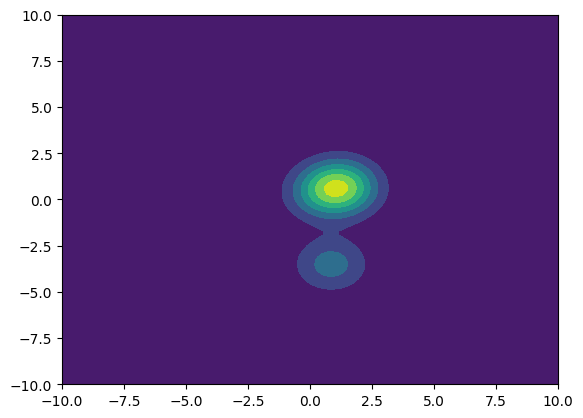

In [81]:
# initialize
n = 2
k = 4
μ = 2*randn(n,k)
Σ = zeros(n,n,k);
Σ[1,1,:] = Σ[2,2,:] = 1
ϕ = ones(k)/k

gx = linspace(-10,10,100);
gy = linspace(-10,10,100);

p = zeros(length(gx),length(gy));
pk = zeros(length(gx),length(gy),k);

for j = 1:length(gy)
    for i = 1:length(gx)
        p[i,j] = GMM([gx[i]; gy[j]],ϕ,μ,Σ);
        for l = 1:k
            pk[i,j,l] = Gaussian([gx[i]; gy[j]],μ[:,l],Σ[:,:,l]); 
        end
    end
end


contourf(gx,gy,p');

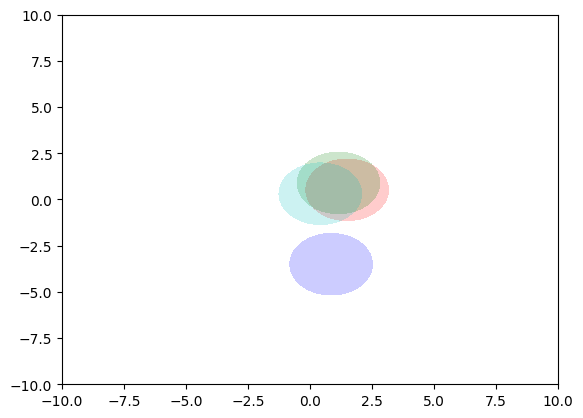

In [82]:
function plotGaussian(μ,Σ,color)
gx = linspace(-10,10,100);
gy = linspace(-10,10,100);

p = zeros(length(gx),length(gy));
#@show μ
for j = 1:length(gy)
    for i = 1:length(gx)
            p[i,j] = Gaussian([gx[i]; gy[j]],μ,Σ); 
        end
    end
    
contourf(gx,gy,p',levels = [0.1,100],colors=color,alpha=0.2)
            end
    
function plotGaussians(μ,Σ,colors = ["r","g","b","c"])
for l = 1:size(μ,2)
    plotGaussian(μ[:,l],Σ[:,:,l],colors[l])
end
end

plotGaussians(μ,Σ)

Sampling from a gaussian mixture
* choose a $z$, an integer number from 1 to $k$. The probability of choosing $z = j$ is $\phi_j$ ($1 \le j \le k$).
* sample from the Gaussian distribution with mean $\vec \mu_j$ and covariance $\mat \Sigma_j$ where $j = z$.


As the data is unlabeld, we do not known from which Gaussian a particular data point is sampled from: $z$ is thus unknown.


## Expectation step

For each sample $i$ and Gaussian $j$, compute the weights $w^{(i)}_j$ wich corresponds to the probability that the sample
$ \vec x^{(i)}$ comes from the Gaussian $j$

$$
w^{(i)}_j = P(z^{(i)} = j \mid \vec x^{(i)})
$$

The Bayes rule allows us to compute these weights:


$$\begin{eqnarray} 
P(z^{(i)} = j \mid \vec x^{(i)}) &=& \frac{P(\vec x^{(i)} \mid z^{(i)} = j) \; P(z^{(i)} = j) } {\sum_{l=1}^k P(\vec x^{(i)} \mid z^{(i)} = l) \; P(z^{(i)} = l) }  \\
&=&  \frac{P(\vec x^{(i)} \mid z^{(i)} = j) \; \phi_j } {\sum_{l=1}^k P(\vec x^{(i)} \mid z^{(i)} = l) \; \phi_l }
\end{eqnarray}$$

where

$$
P(\vec x^{(i)} \mid z^{(i)} = j) = 
\frac{1}{\sqrt{2\pi \det(\mat \Sigma_j)}}
\exp\left(-\frac{1}{2} (\vec x - \vec μ_j)^T  \mat Σ_j^{-1} (\vec x - \vec μ_j) \right)
$$


In [83]:
function expectation_step(x,ϕ,μ,Σ)
    k = length(ϕ)
    N = size(x,2)
    w = zeros(k,N)

    for i = 1:N
        for j = 1:k
            w[j,i] = Gaussian(x[:,i],μ[:,j],Σ[:,:,j]) * ϕ[j]
        end
    
        w[:,i] = w[:,i]/sum(w[:,i])
    end

    return w
end

expectation_step (generic function with 1 method)

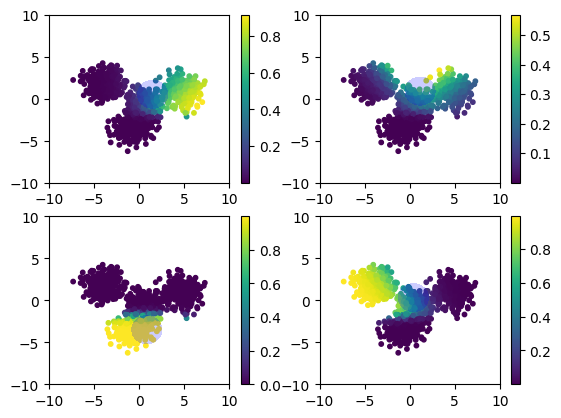

In [84]:
w = expectation_step(x,ϕ,μ,Σ) 

for l = 1:k
    subplot(2,2,l)
    scatter(x[1,:],x[2,:],10,w[l,:]); colorbar();
    plotGaussian(μ[:,l],Σ[:,:,l],"b")
end

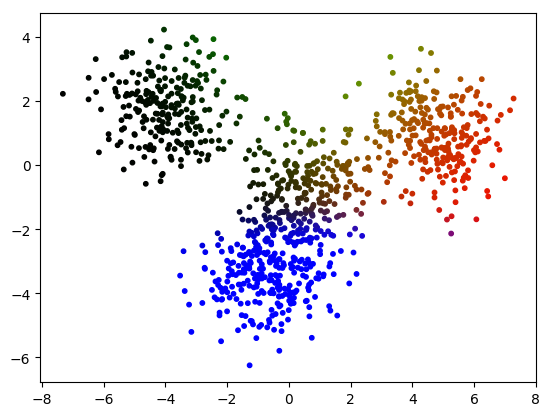

In [85]:
scatter(x[1,:],x[2,:],10,w[1:3,:]'/maximum(w)); 
#scatter(x[1,:],x[2,:],10,P_x_given_c[1:3,:]'/maximum(P_x_given_c)); 

Weighted mean assuming the sum of all elements of `wn` is 1.

In [86]:
function wmean(x,wn)
    μ = zeros(size(x,1));
    for i = 1:size(x,2)
       μ += wn[i] * x[:,i]
    end
    return μ
end
function wcovar(x,wn,μ = wmean(x,wn))
    Σ = zeros(length(μ),length(μ));
    for i = 1:size(x,2)
       Σ += wn[i] * (x[:,i] - μ) * (x[:,i] - μ)'
    end
    return Σ
end
    

wcovar (generic function with 2 methods)

## Maximization step

$$
\phi_j = \frac{1}{N} \sum_{i=1}^N  w^{(i)}_j
$$

Weighted mean:

$$
\vec \mu_j =  \frac{1}{ \sum_{i=1}^N  w^{(i)}_j  }  \sum_{i=1}^N  w^{(i)}_j  \vec x^{(i)}
$$

Weighted covariance:

$$
\mat \Sigma_j =  \frac{1}{ \sum_{i=1}^N  w^{(i)}_j  }  \sum_{i=1}^N  w^{(i)}_j  (\vec x^{(i)} - \vec μ_j) (\vec x^{(i)} - \vec μ_j)^T
$$



In [87]:
function maximization_step!(x,w,ϕ,μ,Σ)
    k = length(ϕ)
    N = size(x,2)

    for j = 1:k
        sumw = sum(w[j,:])
        # normalized weights 
        wn = w[j,:]/sumw
        
        ϕ[j] = sumw/N        
        μ[:,j] = wmean(x,wn)
        Σ[:,:,j] = wcovar(x,wn,μ[:,j])
    end
end


maximization_step! (generic function with 1 method)

In [88]:
#maximization_step!(x,w,ϕ,μ,Σ)
size(w)

(4, 1000)

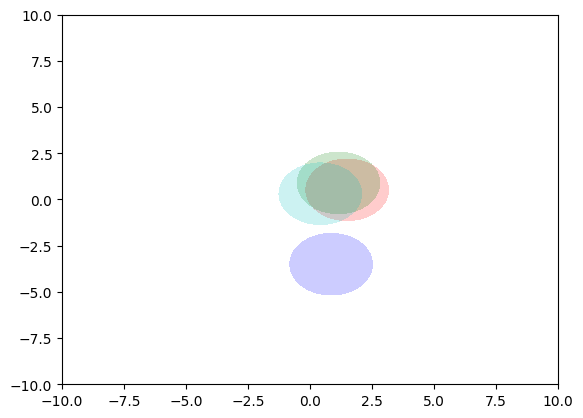

In [89]:
plotGaussians(μ,Σ)


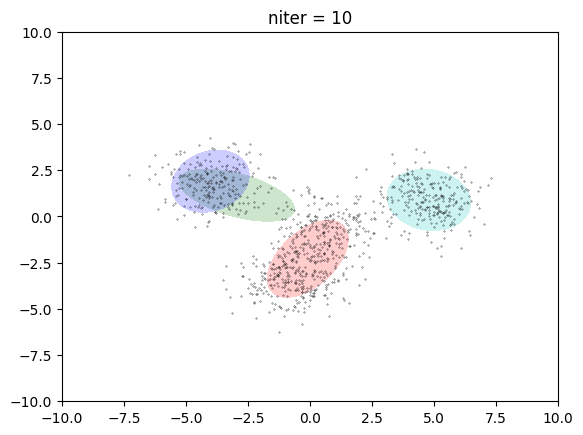

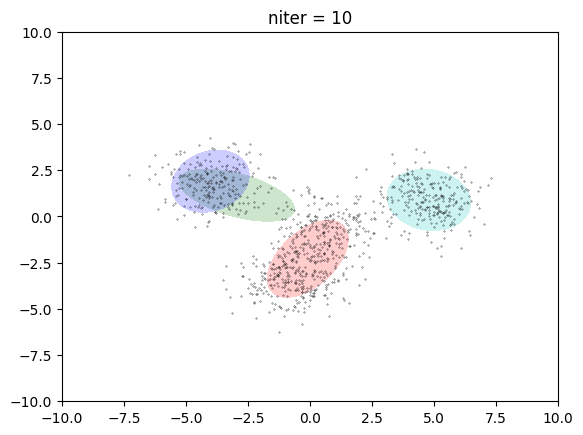

In [95]:
k = 4
μ = 2*randn(n,k)
Σ = zeros(n,n,k);
Σ[1,1,:] = Σ[2,2,:] = 1
ϕ = ones(k)/k

fig = figure()

for niter = 1:10
    w = expectation_step(x,ϕ,μ,Σ)  

    maximization_step!(x,w,ϕ,μ,Σ)
    
    if niter % 1 == 0
        clf()
        plot(x[1,:],x[2,:],"k.",markersize=0.5)
        plotGaussians(μ,Σ)
        sleep(1)
        title("niter = $(niter)")
        IJulia.clear_output(true)
        display(fig)
    end
end